In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=1, sigma=.3)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=0, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.2)
    beta_H = pm.Normal("beta_H", mu=1, sigma=.2)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    # beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    # alpha_2 = pm.Normal("alpha_2", mu=30, sigma=5)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)
    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / (n_LF**(beta_L)) + 1 / (n_HF**(beta_H)))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [5]:
error_mean

0.07751065322334456

In [6]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 24 seconds.


In [7]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 1MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     beta_H   (chain, draw) float64 192kB 1.531 1.51 1.513 ... 1.521 1.486 1.52
     beta_L   (chain, draw) float64 192kB 1.287 1.315 1.324 ... 1.284 1.3 1.282
     eta      (chain, draw) float64 192kB 0.7911 0.8024 0.811 ... 0.7671 0.8
     rho      (chain, draw) float64 192kB 5.815 5.877 6.336 ... 5.453 6.116 5.597
     sigma    (chain, draw) float64 192kB 0.3138 0.3105 0.3122 ... 0.3131 0.3048
 Attributes:
     created_at:                 2024-07-17T03:30:40.234502+00:00
     arviz_version:              0.18.0
     inference_library:          pymc
     inference_library_version:  5.16.1
     sampling_time:              23.72234010696411
     tuning_steps:               2000,
 'sample_stats': <xarray.Dataset> Size: 3MB
 Dimensions:                (chain: 4, d

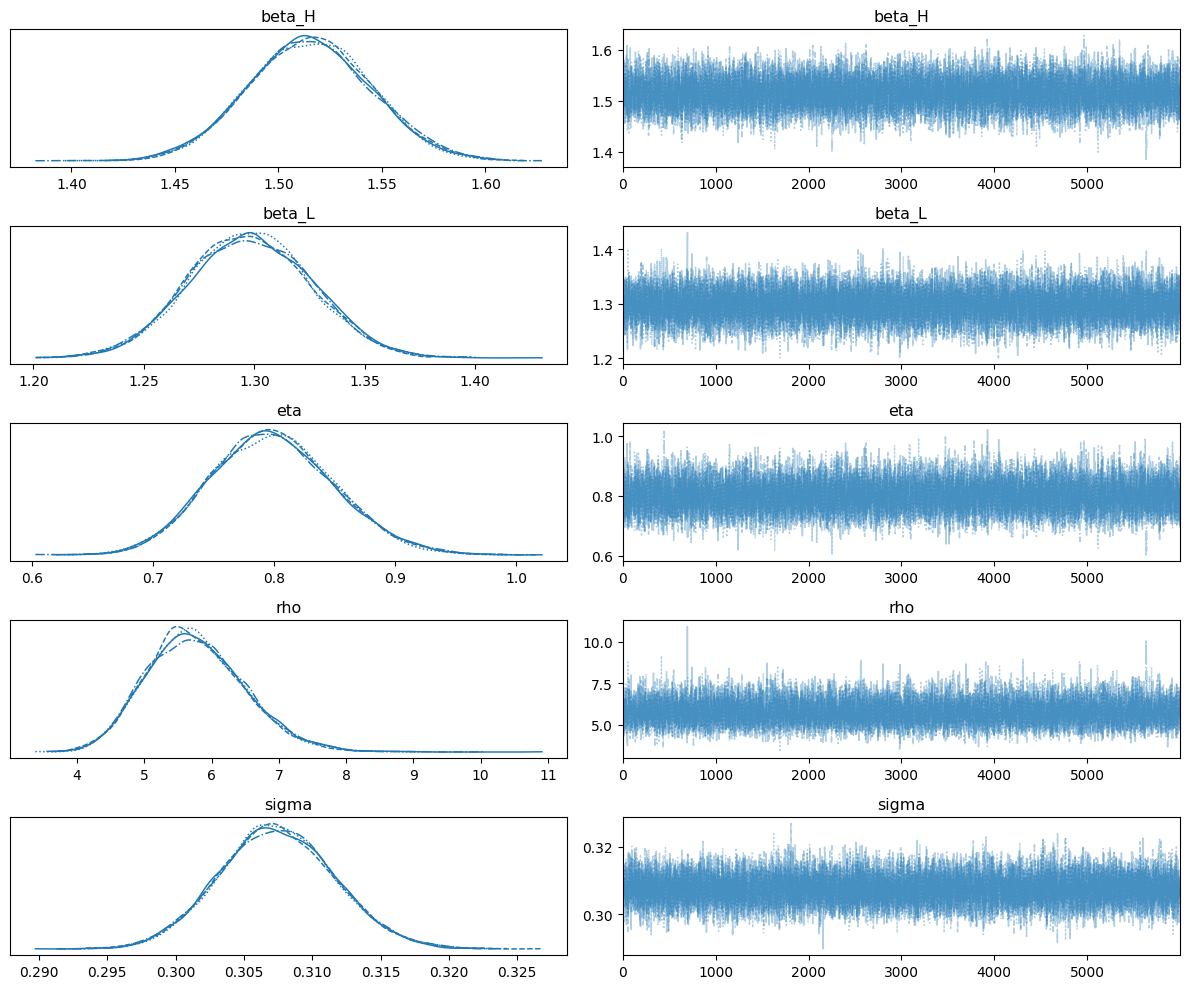

In [8]:
az.plot_trace(idata)
plt.tight_layout()

In [9]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[0.74778905 0.79735189 0.84980121]
[5.04401545 5.71662142 6.48872707]
[1.27039602 1.29763611 1.32561439]
[1.48560638 1.51510188 1.54484505]


In [10]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_H,1.515,0.030,1.459,1.570,0.000,0.000,10396.232,12598.200,1.0
beta_L,1.298,0.028,1.246,1.349,0.000,0.000,11732.652,13918.836,1.0
eta,0.799,0.051,0.704,0.894,0.000,0.000,10688.809,12770.840,1.0
rho,5.767,0.729,4.454,7.138,0.007,0.005,9592.185,11804.643,1.0
sigma,0.307,0.004,0.299,0.315,0.000,0.000,14576.917,13888.489,1.0


In [20]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
beta_H: 1.5156154430804256
beta_L: 1.2974943261842817
eta: 0.7947996701660118
rho: 5.608704513443982
sigma: 0.30695835929339044


In [11]:
posterior_eta.values.flatten()

array([0.79113987, 0.80244503, 0.81097506, ..., 0.79708001, 0.76710427,
       0.80003917])

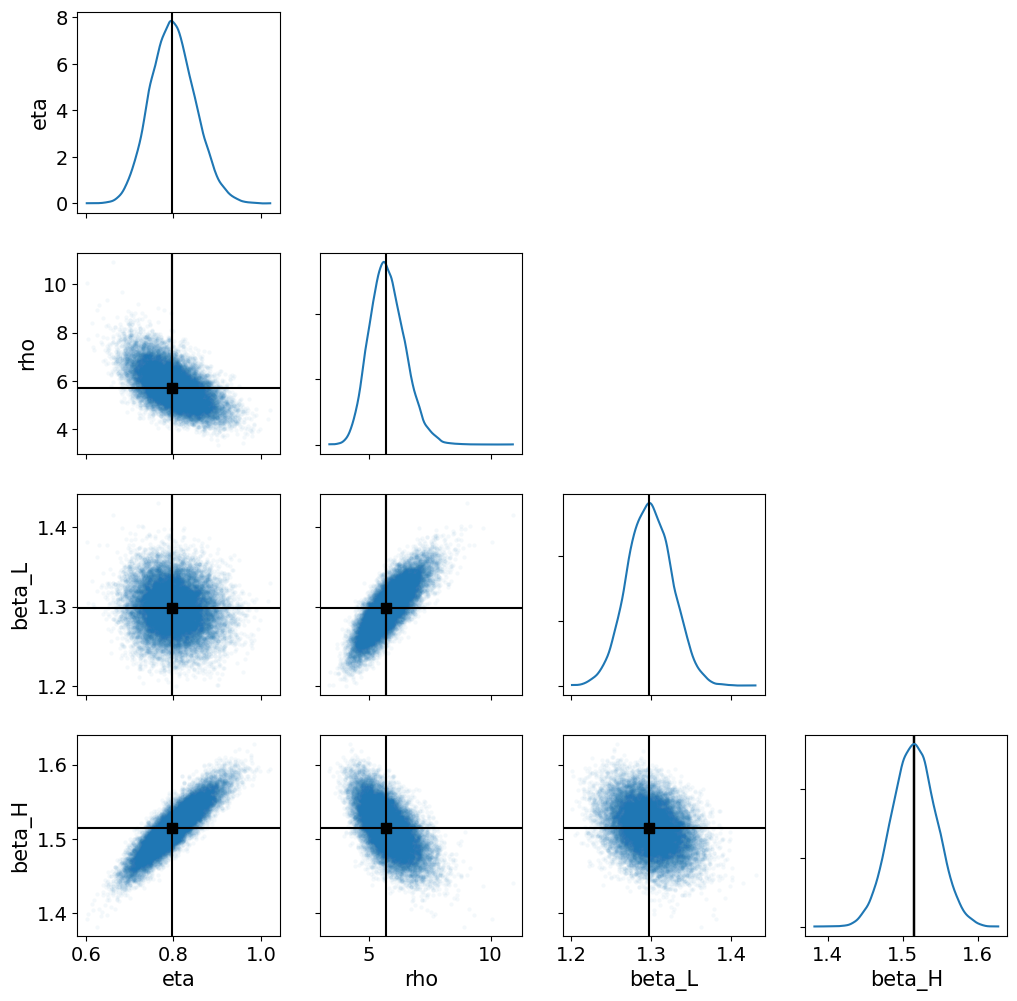

In [12]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [36]:
# naive lg_Phi
def error_function(n_LF, n_HF):
    eta = 0.7947996701660118
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 5.608704513443982
    beta_L = 1.2974943261842817
    beta_H = 1.5156154430804256

    sigma_lg_Phi = 0.30695835929339044	   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / (n_LF**(beta_L)) + 1 / (n_HF**(beta_H)))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [37]:
# loss  mean

lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [38]:
loss

4.468037162243278